# Baran14 Ice Optics Parameterization (v1a)

## Setting up LUT

Here, we are creating look-up-tables (LUT) for optical properties such as extinction coefficients, single scatter albedo $\omega_0$ and assymetry parameter $g$ for ice cloud parameter ranges used in Test 1 (Altitude/Temperature):

* Ice Mass Mixing ratio $q_i$ $\left[\frac{\text{kg of ice}}{\text{kg of air}}\right]$ range: 

$$q_i = \left(\text{0.04 to 0.11} \; \left[\frac{\text{g of ice}}{\text{kg of air}}\right]\right) \; \times \; 0.001 \; \left[\frac{\text{kg of ice}}{\text{g of ice}}\right]$$

* Ice Water Content IWC ($g$ $m^{-3}$) (We're using an average density of 0.3 $kg$ $m^{-3}$ between 10 km and 15 km):

$$IWC = q_i \left[\frac{\text{kg of ice}}{\text{kg of air}}\right] * 1000 \left[\frac{\text{g of ice}}{\text{kg of ice}}\right] * 0.3 \left[\frac{\text{kg of air}}{m^3}\right]$$

* Ice Water Path IWP ($g/m^2$) range: 0.1 to 300.1 $g/m^2$

* Fixed Effective Radius $r_e (\mu m)$ (not needed for this case)

* Temperature T (K) range: 190 to 260.5 

In [1]:
import numpy as np
import xarray as xr
import netCDF4 as nc
import math
import pandas as pd
from scipy import interpolate

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from matplotlib.ticker import LinearLocator

%matplotlib notebook

# Baran scheme (Baran et al. 2014)

In [2]:
data_path = ('/groups/sylvia/ecrad_tests/ecrad_rad_data_backup/')
file      = 'baran_ice_scattering_rrtm.nc'
baran14   = xr.open_dataset(data_path+file)

In [3]:
baran14

<xarray.Dataset>
Dimensions:         (band_lw: 16, band_sw: 14, coeff: 9)
Dimensions without coordinates: band_lw, band_sw, coeff
Data variables:
    wavenumber1_lw  (band_lw) float32 ...
    wavenumber2_lw  (band_lw) float32 ...
    wavenumber1_sw  (band_sw) float32 ...
    wavenumber2_sw  (band_sw) float32 ...
    coeff_lw        (band_lw, coeff) float32 ...
    coeff_sw        (band_sw, coeff) float32 ...
Attributes:
    comment:  This file provides a parameterization of ice particle scatterin...

In [4]:
# SHORTWAVE
# Lower bound wavenumber (cm-1) for shortwave band.
baran14_sw_wn1 = baran14.variables['wavenumber1_sw'][:]
baran14_sw_wl1 = 1e4 / baran14_sw_wn1 # (um)

# Upper bound wavenumber (cm-1) for shortwave band.
baran14_sw_wn2 = baran14.variables['wavenumber2_sw'][:]
baran14_sw_wl2 = 1e4 / baran14_sw_wn2 # (um)

# Shortwave Coefficients (10 coefficients in total):
baran14_sw_coeff = baran14.variables['coeff_sw'][:]



# LONGWAVE
# Lower bound wavenumber (cm-1) for longwave band.
baran14_lw_wn1 = baran14.variables['wavenumber1_lw'][:]
baran14_lw_wl1 = 1e4/baran14_lw_wn1 # (um)

# Upper bound wavenumber (cm-1) for longwave band. See Tables
baran14_lw_wn2 = baran14.variables['wavenumber2_lw'][:]
baran14_lw_wl2 = 1e4 / baran14_lw_wn2 # (um)

# Longwave Coefficients:
baran14_lw_coeff = baran14.variables['coeff_lw'][:]

In [5]:
# Pandas DataFrame for visualization:

# SW:
baran14_sw_band_lim    = []
baran14_sw_band_lim_cm = []
for wl in range(len(baran14_sw_wl1)):
    wl2_str = str(round(float(baran14_sw_wl2[wl]),3))
    wl1_str = str(round(float(baran14_sw_wl1[wl]),3))
    wn2_str = str(int(baran14_sw_wn2[wl]))
    wn1_str = str(int(baran14_sw_wn1[wl]))
    baran14_sw_band_lim.append(wl2_str + ' - ' + wl1_str)
    baran14_sw_band_lim_cm.append(wn1_str + ' - ' + wn2_str)
baran14_sw_tables = pd.DataFrame({'Band limits (um)': baran14_sw_band_lim,
                                  'Band limits (cm-1)': baran14_sw_band_lim_cm,
                                  'p1 (a)': baran14_sw_coeff[:,0],
                                  'p2': baran14_sw_coeff[:,1],
                                  'p3': baran14_sw_coeff[:,2],
                                  'p4 (b/a)': baran14_sw_coeff[:,3],
                                  'p5': baran14_sw_coeff[:,4],
                                  'p6': baran14_sw_coeff[:,5],
                                  'p7': baran14_sw_coeff[:,6],
                                  'p8': baran14_sw_coeff[:,7],
                                  'p9': baran14_sw_coeff[:,8]
                                 })
baran14_sw_tables = baran14_sw_tables.set_index('Band limits (um)')

# LW:
baran14_lw_band_lim = []
baran14_lw_band_lim_cm = []
for wn in range(len(baran14_lw_wn1)):
    wl2_str = str(round(float(baran14_lw_wl2[wn]),3))
    wl1_str = str(round(float(baran14_lw_wl1[wn]),3))
    wn2_str = str(int(baran14_lw_wn2[wn]))
    wn1_str = str(int(baran14_lw_wn1[wn]))
    baran14_lw_band_lim.append(wl2_str + ' - ' + wl1_str)
    baran14_lw_band_lim_cm.append(wn1_str + ' - ' + wn2_str)
baran14_lw_tables = pd.DataFrame({'Band limits (um)': baran14_lw_band_lim,
                                  'Band limits (cm-1)': baran14_lw_band_lim_cm,
                                  'p1 (a)': baran14_lw_coeff[:,0],
                                  'p2': baran14_lw_coeff[:,1],
                                  'p3': baran14_lw_coeff[:,2],
                                  'p4 (b/a)': baran14_lw_coeff[:,3],
                                  'p5': baran14_lw_coeff[:,4],
                                  'p6': baran14_lw_coeff[:,5],
                                  'p7': baran14_lw_coeff[:,6],
                                  'p8': baran14_lw_coeff[:,7],
                                  'p9': baran14_lw_coeff[:,8]
                                 })
baran14_lw_tables = baran14_lw_tables.set_index('Band limits (um)')

## Computing Optical Properties with Baran14 (Shortwave)

1. Check equations

In [6]:
pd.options.display.float_format = '{:.6e}'.format
#pd.reset_option('format')
#fu_sw_tables.style.format({'a0': '{:10.6e}'})
baran14_sw_tables

,Band limits (cm-1),p1 (a),p2,p3,p4 (b/a),p5,p6,p7,p8,p9
Band limits (um),,,,,,,,,,
3.077 - 3.846,2600 - 3250,5.060230e+01,3.967990e+00,1.198910e+06,5.645110e-01,9.939790e-02,1.724540e+04,9.314540e-01,-8.017100e-02,3.933330e+04
2.5 - 3.077,3250 - 4000,5.084610e+01,-5.787800e-01,1.405770e+04,6.441110e-01,1.434080e-01,1.001700e+04,9.406920e-01,-4.428250e-02,7.539750e+03
2.151 - 2.5,4000 - 4650,5.056190e+01,2.769110e+00,1.077270e+06,8.318650e-01,1.489940e-01,7.901200e+03,8.829310e-01,-6.187950e-02,9.164290e+03
1.942 - 2.151,4650 - 5150,5.054590e+01,1.578530e+00,2.033680e+06,6.944560e-01,2.466300e-01,1.076500e+04,9.186270e-01,-1.049190e-01,1.428570e+04
1.626 - 1.942,5150 - 6150,5.052410e+01,2.383140e+00,2.285750e+06,8.567470e-01,1.266450e-01,7.797910e+03,8.600720e-01,-6.989570e-02,1.585720e+04
1.299 - 1.626,6150 - 7700,5.051700e+01,4.161950e+00,2.006880e+06,8.844930e-01,1.027620e-01,7.862290e+03,8.447240e-01,-5.773570e-02,1.516600e+04
1.242 - 1.299,7700 - 8050,5.050930e+01,3.416010e+00,2.169830e+06,9.852990e-01,1.390430e-02,1.342000e+04,8.069150e-01,-2.756930e-02,6.658700e+04
0.778 - 1.242,8050 - 12850,5.053400e+01,1.777380e+00,1.651870e+06,9.978630e-01,2.029730e-03,1.428570e+04,7.987620e-01,-2.804480e-02,2.134640e+05
0.625 - 0.778,12850 - 16000,5.054710e+01,1.174280e+00,1.385570e+06,9.998520e-01,1.438570e-04,1.428570e+04,7.956770e-01,-2.784120e-02,2.666690e+05


In [ ]:
q_i = np.arange(0.1e-3,3.5001,0.1e-3) * 0.001

In [ ]:
len(q_i)

In [7]:
# Ice Mass Mixing ratio qi (kg/kg):
q_i = np.arange(0.04, 0.11, 0.001) * 0.001 # Range used in Test 1 - Altitude/Temperature.

# Ice Water Content IWC (g/m3) (We use an average density of 0.3 kg m-3 between 10 km and 15 km):
iwc = q_i * 1000 * 0.3

# Ice Water Path IWP (g/m2):
#iwp = np.arange(0.1, 300.1, 0.1)

# Effective Radius r_e (um) not needed for this case

# Effective Diameter D_e (um) not needed for this case

# For SHORTWAVE:
# Extinction Coefficient Beta_ext (1/m)
baran14_sw_b_ext = np.zeros((len(baran14_sw_wn1), len(q_i)))
# Mass Extinction Coefficient K_ext (m2/kg)
baran14_sw_K_ext = np.zeros((len(baran14_sw_wn1), len(q_i)))
# Mass Absorption Coefficient K_abs (m2/kg)
baran14_sw_K_abs = np.zeros((len(baran14_sw_wn1), len(q_i)))
# Optical Depth OD (Following Hogan equations in "radiation_ice_optics_baran.F90"):
baran14_sw_od    = np.zeros((len(baran14_sw_wn1), len(q_i)))

# Single Scatter Albedo:
baran14_sw_ssa     = np.zeros((len(baran14_sw_wn1), len(q_i)))
# Scattering Optical Depth (Following Hogan equations in "radiation_ice_optics_baran.F90"):
baran14_sw_scat_od = np.zeros((len(baran14_sw_wn1), len(q_i)))

# Asymmetry Factor:
baran14_sw_g = np.zeros((len(baran14_sw_wn1), len(q_i)))

# Calculations following Hogan equation given in comments of 'baran_ice_scattering_rrtm.nc':
for wn_ix in range(len(baran14_sw_wn1)):
    p1 = baran14_sw_coeff[wn_ix, 0] # Coefficient p1
    p2 = baran14_sw_coeff[wn_ix, 1] # Coefficient p2
    p3 = baran14_sw_coeff[wn_ix, 2] # Coefficient p3
    p4 = baran14_sw_coeff[wn_ix, 3] # Coefficient p4
    p5 = baran14_sw_coeff[wn_ix, 4] # Coefficient p5
    p6 = baran14_sw_coeff[wn_ix, 5] # Coefficient p6
    p7 = baran14_sw_coeff[wn_ix, 6] # Coefficient p7
    p8 = baran14_sw_coeff[wn_ix, 7] # Coefficient p8
    p9 = baran14_sw_coeff[wn_ix, 8] # Coefficient p9
    for iwc_ix in range(len(iwc)):
        qi_i  = q_i[iwc_ix] # kg kg-1
        iwc_i = iwc[iwc_ix] # g m-3
        #iwp_i = iwp[iwc_ix] # Adjusted to be same length than Ice Water Content

        # Mass Extinction Coefficient Kext (m2/g):
            # Version given in .nc comments (corrected from Baran et al. 2014). Hogans: typo error
        #K_ext_i = 0.001 * qi_i * (p1 + (p2 / (1 + qi_i * p3)))
            # Version given in Hogan's fortran code (corrected from Baran et al. 2014). The right one:
        K_ext_i = 0.001 * (p1 + (p2 / (1 + qi_i * p3))) 
        #K_ext_i = 0.001 * qi_i * p1 # Version given in Baran et al. 2014
        baran14_sw_K_ext[wn_ix, iwc_ix] = K_ext_i
        
        # Optical Depth:
        # Optical Depth from Eq. in "radiation_ice_optics_baran.F90" by Hogan where iwp is transformed to kg/m2:
        #od_i    = iwp_i * 0.001 (p1 + (p2 / (1 + qi_i * p3))) # od_i = iwp_i * 0.001 * qi_i * (p1 + (p2 / (1 + qi_i * p3)))
        #baran14_sw_od[wn_ix, d_ix, iwc_ix] = od_i
    
        # Single Scatter Albedo from Hogan:
        ssa_i = p4 + (p5 / (1 + qi_i * p6))
        baran14_sw_ssa[wn_ix, iwc_ix] = ssa_i
        
        # Scattering Optical Depth from Eq. in "radiation_ice_optics_baran.F90" by Hogan:
        #scat_od_i = od_i*(p4 + (p5 / (1 + qi_i * p6)))
        #baran14_sw_scat_od[wn_ix, d_ix, iwc_ix] = scat_od_i
        
        # Mass Absorption Coefficient Kabs (m2/kg) (as Kext*(1-ssa)):
        K_abs_i = K_ext_i*(1 - ssa_i)
        baran14_sw_K_abs[wn_ix, iwc_ix] = K_abs_i
        
        # Assymetry Parameter from Eq. in "radiation_ice_optics_baran.F90" by Hogan:
        g_i = p7 + (p8 / (1 + qi_i*p9))
        baran14_sw_g[wn_ix, iwc_ix] = g_i

### Saving 3d tables for Ke, Ka, w and g for Baran2014 SW

In [8]:
baran14_sw = xr.Dataset(
    data_vars = dict(
        K_ext = (['sw_wn_1', 'iwc'], baran14_sw_K_ext),
        K_abs = (['sw_wn_1', 'iwc'], baran14_sw_K_abs),
        ssa = (['sw_wn_1', 'iwc'], baran14_sw_ssa),
        g = (['sw_wn_1', 'iwc'], baran14_sw_g),
    ),
    attrs = dict(
        title="LUT for Baran14 SW. Ranges for Altitude-Temperature Test."),
)

In [8]:
out_dir = ('/groups/sylvia/ecrad_tests/LUT_SchComp/')
file    = 'Baran14SW_test1_LUT_v1a.nc'
baran14_sw.to_netcdf(path = out_dir+file)

## Computing Optical Properties with Baran14 (Longwave)

1. Check equations

In [9]:
pd.options.display.float_format = '{:.6e}'.format
#pd.reset_option('format')
#fu_sw_tables.style.format({'a0': '{:10.6e}'})
baran14_lw_tables

,Band limits (cm-1),p1 (a),p2,p3,p4 (b/a),p5,p6,p7,p8,p9
Band limits (um),,,,,,,,,,
28.571 - 1000.0,10 - 350,5.127380e+01,-1.488550e+01,1.430160e+06,5.234560e-01,-1.542760e-01,1.506420e+05,8.976500e-01,-3.218530e-01,1.318850e+05
20.0 - 28.571,350 - 500,5.239470e+01,-6.191520e+00,3.355370e+06,5.666460e-01,2.316680e-01,1.528360e+04,9.282720e-01,-1.852980e-01,2.988710e+04
15.873 - 20.0,500 - 630,5.089710e+01,1.941100e+00,2.180850e+04,5.463590e-01,1.186690e-01,4.170330e+04,9.336700e-01,-1.392230e-01,6.003520e+04
14.286 - 15.873,630 - 700,5.071520e+01,3.048290e+00,5.409410e+04,5.494660e-01,5.551180e-03,1.428570e+04,9.254460e-01,-1.109810e-01,1.416940e+05
12.195 - 14.286,700 - 820,5.069250e+01,1.470000e+00,6.870720e+04,5.510070e-01,-8.164700e-02,1.046920e+05,9.203530e-01,-8.320650e-02,3.437960e+05
10.204 - 12.195,820 - 980,5.031070e+01,-7.150870e+00,1.155440e+06,5.284930e-01,-1.179980e-01,1.547050e+05,9.494630e-01,-5.897370e-02,3.062730e+05
9.259 - 10.204,980 - 1080,5.103250e+01,-5.708110e+00,2.271050e+06,5.284560e-01,1.484110e-01,2.469120e+04,9.734730e-01,-6.103710e-02,5.483120e+04
8.475 - 9.259,1080 - 1180,5.099960e+01,-2.707570e-01,1.382250e+04,5.364210e-01,1.983870e-01,3.570090e+04,9.685640e-01,-7.159560e-02,4.778640e+04
7.194 - 8.475,1180 - 1390,5.070600e+01,1.401110e+00,6.050240e+04,5.394560e-01,1.713860e-01,6.582800e+04,9.651320e-01,-7.781050e-02,6.661380e+04


In [10]:
# Ice Mass Mixing ratio qi (kg/kg):
q_i = np.arange(0.04, 0.11, 0.001) * 0.001 # Range used in Test 1 - Altitude/Temperature.

# Ice Water Content IWC (g/m3) (We use an average density of 0.3 kg m-3 between 10 km and 15 km):
iwc = q_i * 1000 * 0.3

# Ice Water Path IWP (g/m2):
#iwp = np.arange(0.1, 300.1, 0.1)

# Effective Radius r_e (um) not needed for this case

# Effective Diameter D_e (um) not needed for this case

# For SHORTWAVE:
# Extinction Coefficient Beta_ext (1/m)
baran14_lw_b_ext = np.zeros((len(baran14_lw_wn1), len(q_i)))
# Mass Extinction Coefficient K_ext (m2/kg)
baran14_lw_K_ext = np.zeros((len(baran14_lw_wn1), len(q_i)))
# Mass Absorption Coefficient K_ext (m2/kg)
baran14_lw_K_abs = np.zeros((len(baran14_lw_wn1), len(q_i)))
# Optical Depth OD (Following Hogan equations in "radiation_ice_optics_baran.F90"):
baran14_lw_od    = np.zeros((len(baran14_lw_wn1), len(q_i)))

# Single Scatter Albedo:
baran14_lw_ssa     = np.zeros((len(baran14_lw_wn1), len(q_i)))
# Scattering Optical Depth (Following Hogan equations in "radiation_ice_optics_baran.F90"):
baran14_lw_scat_od = np.zeros((len(baran14_lw_wn1), len(q_i)))

# Asymmetry Factor:
baran14_lw_g = np.zeros((len(baran14_lw_wn1), len(q_i)))

# Calculations following Hogan equation given in comments of 'baran_ice_scattering_rrtm.nc':
for wn_ix in range(len(baran14_lw_wn1)):
    p1 = baran14_lw_coeff[wn_ix, 0] # Coefficient p1
    p2 = baran14_lw_coeff[wn_ix, 1] # Coefficient p2
    p3 = baran14_lw_coeff[wn_ix, 2] # Coefficient p3
    p4 = baran14_lw_coeff[wn_ix, 3] # Coefficient p4
    p5 = baran14_lw_coeff[wn_ix, 4] # Coefficient p5
    p6 = baran14_lw_coeff[wn_ix, 5] # Coefficient p6
    p7 = baran14_lw_coeff[wn_ix, 6] # Coefficient p7
    p8 = baran14_lw_coeff[wn_ix, 7] # Coefficient p8
    p9 = baran14_lw_coeff[wn_ix, 8] # Coefficient p9
    for iwc_ix in range(len(iwc)):
        qi_i  = q_i[iwc_ix] # kg kg-1
        iwc_i = iwc[iwc_ix] # g m-3
        #iwp_i = iwp[iwc_ix] # Adjusted to be same length than Ice Water Content

        # Mass Extinction Coefficient Kext (m2/g):
            # Version given in .nc comments (corrected from Baran et al. 2014). Hogans: typo error
        #K_ext_i = 0.001 * qi_i * (p1 + (p2 / (1 + qi_i * p3)))
            # Version given in Hogan's fortran code (corrected from Baran et al. 2014). The right one:
        K_ext_i = 0.001 * (p1 + (p2 / (1 + qi_i * p3)))
        #K_ext_i = 0.001 * qi_i * p1 # Version given in Baran et al. 2014
        baran14_lw_K_ext[wn_ix, iwc_ix] = K_ext_i
        
        # Optical Depth:
        # Optical Depth from Eq. in "radiation_ice_optics_baran.F90" by Hogan where iwp is transformed to kg/m2:
        #od_i    = iwp_i * 0.001 (p1 + (p2 / (1 + qi_i * p3))) # od_i = iwp_i * 0.001 * qi_i * (p1 + (p2 / (1 + qi_i * p3)))
        #baran14_sw_od[wn_ix, d_ix, iwc_ix] = od_i
  
        # Single Scatter Albedo from Hogan:
        ssa_i = p4 + (p5 / (1 + qi_i * p6))
        baran14_lw_ssa[wn_ix, iwc_ix] = ssa_i
        
        # Scattering Optical Depth from Eq. in "radiation_ice_optics_fu.F90" by Hogan:
        #scat_od_i = od_i*(1 - b0 + b1*d_i + b2*d_i**2 + b3*d_i**3)
        #fu_sw_scat_od[wn_ix, d_ix, iwc_ix] = scat_od_i

        # Mass Absorption Coefficient Kabs (m2/kg) (as Kext*(1-ssa)):
        K_abs_i = K_ext_i*(1 - ssa_i)
        baran14_lw_K_abs[wn_ix, iwc_ix] = K_abs_i
        
        # Assymetry Parameter from Eq. in "radiation_ice_optics_baran.F90" by Hogan:
        g_i = p7 + (p8 / (1 + qi_i*p9))
        baran14_lw_g[wn_ix, iwc_ix] = g_i

### Saving 3d tables for Ke, Ka, w and g for Baran2014 LW

In [11]:
baran14_lw = xr.Dataset(
    data_vars = dict(
        K_ext = (['lw_wn_1', 'iwc'], baran14_lw_K_ext),
        K_abs = (['lw_wn_1', 'iwc'], baran14_lw_K_abs),
        ssa = (['lw_wn_1', 'iwc'], baran14_lw_ssa),
        g = (['lw_wn_1', 'iwc'], baran14_lw_g),
    ),
    attrs = dict(
        title="LUT for Baran14 LW. Ranges for Altitude-Temperature Test."),
)

In [11]:
out_dir = ('/groups/sylvia/ecrad_tests/LUT_SchComp/')
file    = 'Baran14LW_test1_LUT_v1a.nc'
baran14_lw.to_netcdf(path = out_dir+file)

## Plotting Baran14 Optical parameters vs Wavelength and IWC

ALL BANDS

<IPython.core.display.Javascript object>


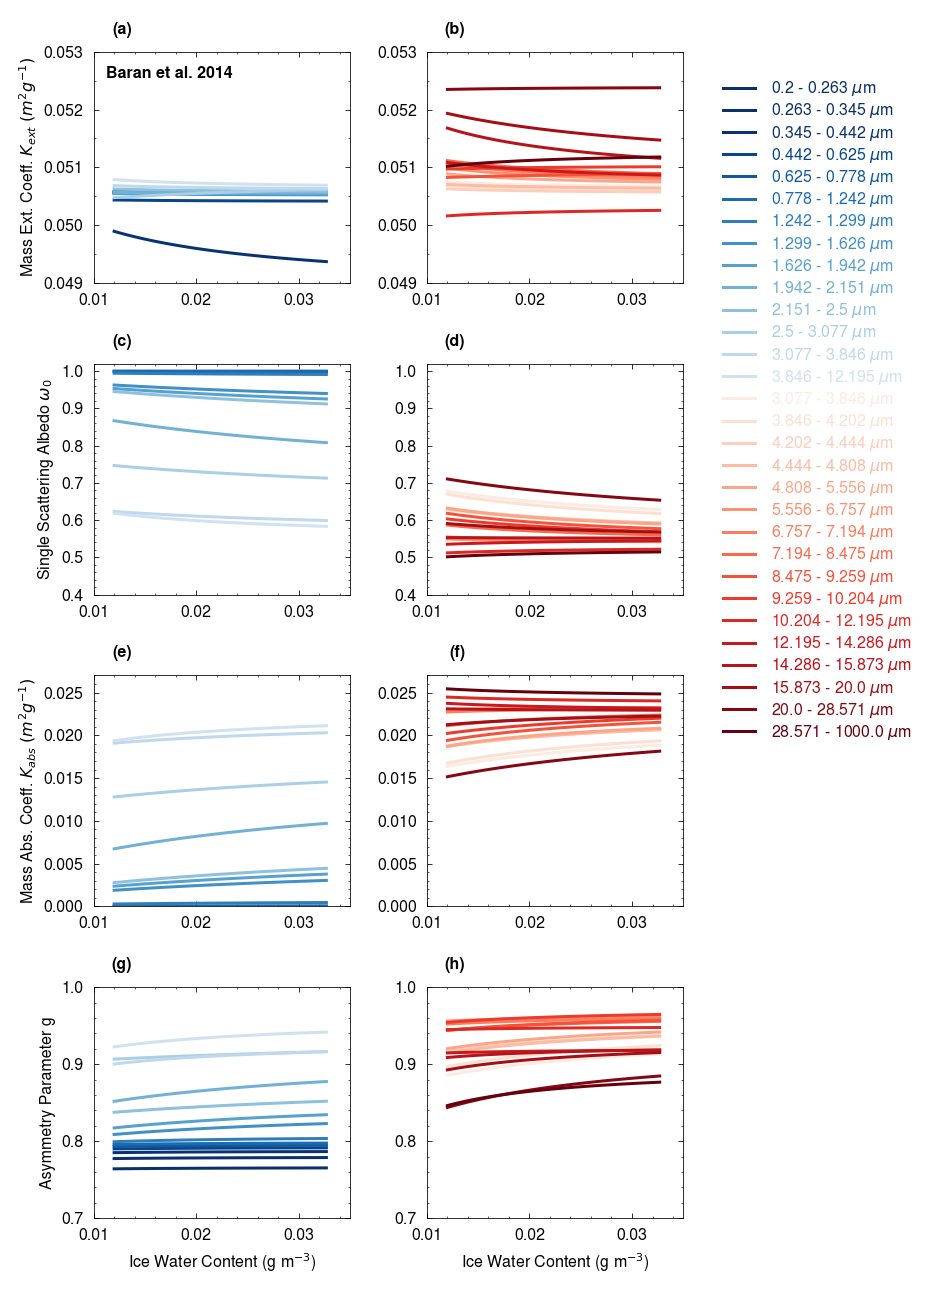

In [28]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 18 # inches
flength  = 13 # inches


rows    = 4
columns = 2
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.96, bottom = 0.06, left = 0.1, right = 0.73, 
                    hspace = .35, wspace = .3)


rad_comps       = ['sw', 'lw']
opt_props       = ['K_ext', 'ssa', 'K_abs', 'g']
opt_props_label = [r'Mass Ext. Coeff. $K_{ext}$ $(m^2g^{-1})$', r'Single Scattering Albedo $\omega_0$',
                   r'Mass Abs. Coeff. $K_{abs}$ $(m^2g^{-1})$', 'Asymmetry Parameter g']
panel_letters   = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']
panel_letters_i = 0

for opt_prop in range(rows):
    handles = []
    labels  = []
    for rad_comp in range(columns):
        baran14_plot = eval('baran14_'+rad_comps[rad_comp]+'_'+opt_props[opt_prop])
        if rad_comp == 0: bands = list(np.arange(0,13)[::-1]) + [13]
        if rad_comp == 1: bands = list(np.arange(0,16)[::-1])
        for band in bands:
            if rad_comp == 0: color = matplotlib.cm.Blues(.9 - (len(bands)-bands[::-1].index(band))/len(bands) + .3)
            if rad_comp == 1: color = matplotlib.cm.Reds(.1 + (len(bands)-bands[::-1].index(band))/len(bands) - .1)
            h = ax[opt_prop, rad_comp].plot(iwc, baran14_plot[band, :],
                                            linestyle = 'solid', 
                                            linewidth = 3, color = color)
            handles = handles + h
            #if rad_comp == 0:
            label = (str(round(float(1e4/eval('baran14_'+rad_comps[rad_comp]+'_wn2')[band]),3)) + ' - ' +  
                     str(round(float(1e4/eval('baran14_'+rad_comps[rad_comp]+'_wn1')[band]),3)) + r' $\mu$m')
#             if rad_comp == 1:
#                 label = (str(int(eval('baran14_'+rad_comps[rad_comp]+'_wn1')[band])) + ' - ' +  
#                          str(int(eval('baran14_'+rad_comps[rad_comp]+'_wn2')[band])) + r' $cm^{-1}$')    
            labels.append(label)

        # X Axis:
        if opt_prop == 3:
            ax[opt_prop, rad_comp].set_xlabel(r'Ice Water Content (g m$^{-3}$)', 
                                              fontsize = fontsize, fontname = fontname,
                                              color ='black', labelpad = 7.5)
        ax[opt_prop, rad_comp].set_xlim(0.01, 0.035)
        ax[opt_prop, rad_comp].xaxis.set_major_locator(ticker.MultipleLocator(0.01))
        ax[opt_prop, rad_comp].xaxis.set_minor_locator(ticker.MultipleLocator(0.002))
        ax[opt_prop, rad_comp].tick_params(axis = 'x', which = 'major', color = 'black',
                                           size = 4, direction = 'in', top = True,
                                           labelsize = fontsize, pad = 10)
        for tick in ax[opt_prop, rad_comp].get_xticklabels():
            tick.set_fontname(fontname)
        
        ax[opt_prop, rad_comp].tick_params(axis = 'y', which = 'major', color = 'black',
                                           size = 4, direction = 'in', right = True,
                                           labelsize = fontsize, pad = 10)
        for tick in ax[opt_prop, rad_comp].get_yticklabels():
            tick.set_fontname(fontname)
 
        # Y Axis:
        opt_props_labeli = opt_props_label[opt_prop]
        if rad_comp == 0:
            ax[opt_prop, rad_comp].set_ylabel(opt_props_labeli, fontsize = fontsize, 
                                              fontname = fontname, color ='black', labelpad = 5) 
        if opt_prop == 0: # Mass Extinction Coefficient
            ax[opt_prop, rad_comp].set_ylim(0.049, 0.053)
            ax[opt_prop, rad_comp].yaxis.set_major_locator(ticker.MultipleLocator(0.001))
            ax[opt_prop, rad_comp].yaxis.set_minor_locator(ticker.MultipleLocator(0.0005))
            dummy = True
        elif opt_prop == 1: # SSA
            ax[opt_prop, rad_comp].set_ylim(0.4, 1.02)
            ax[opt_prop, rad_comp].yaxis.set_major_locator(ticker.MultipleLocator(.1))
            ax[opt_prop, rad_comp].yaxis.set_minor_locator(ticker.MultipleLocator(.02))
        elif opt_prop == 2: # Mass Absorption Coefficient
            ax[opt_prop, rad_comp].set_ylim(0, 0.027)
            ax[opt_prop, rad_comp].yaxis.set_major_locator(ticker.MultipleLocator(0.005))
            ax[opt_prop, rad_comp].yaxis.set_minor_locator(ticker.MultipleLocator(0.001))
            dummy = True
        elif opt_prop == 3: # g
            ax[opt_prop, rad_comp].set_ylim(0.7, 1)
            ax[opt_prop, rad_comp].yaxis.set_major_locator(ticker.MultipleLocator(.1))
            ax[opt_prop, rad_comp].yaxis.set_minor_locator(ticker.MultipleLocator(.02))
        # ax[opt_prop, rad_comp].locator_params(axis = 'x', nbins = 6) 
        for tick in ax[opt_prop, rad_comp].get_yticklabels():
            tick.set_fontname(fontname)
            
        # Both axis:
        ax[opt_prop, rad_comp].tick_params(axis = 'both', which = 'major', color = 'black',
                                           size = 5, direction = 'in', top = True, right = True,
                                           labelsize = fontsize, pad = 10)
        ax[opt_prop, rad_comp].tick_params(axis = 'both', which = 'minor', color = 'black', 
                                           size = 2, direction = 'in', top = True, right = True,
                                           labelsize = fontsize, pad = 10)
            
        # Panel letters:
        ax[opt_prop, rad_comp].text(0.15, 1.13, panel_letters[panel_letters_i], weight = 'bold',
                                    ha = 'right', va = 'top', transform = ax[opt_prop, rad_comp].transAxes,
                                    fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1

# Scheme Title:
ax[0, 0].text(0.05, 0.94, 'Baran et al. 2014', weight = 'bold',
              ha = 'left', va = 'top', transform = ax[0, 0].transAxes,
              fontsize = fontsize, fontname = fontname, color = 'black')
        
# Legend:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
legend  = plt.legend(handles, labels, loc = 'upper right',
                     bbox_to_anchor = (.99, .95),
                     bbox_transform = f.transFigure,
                     frameon = False, ncol = 1, columnspacing = 2,
                     labelspacing = .2, labelcolor = 'linecolor',
                     handlelength = 2, handletextpad = 1,
                     prop = {'family': fontname, 'size': fontsize})


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'baran_opt_prop_all_bands_baran14_v1a.png', dpi=500)